# Pré-traitement de nos images

Le code ci-dessous permet de réaliser un pré-traitement en supposant l'emplacement de la forme dans l'image. L'utilisateur appuie sur la touche Espace si l'emplacement prédit est correct ou sinon il trace lui-même l'emplacement prédit.  
  
Un dossier d'erreur est créé avec les images qui n'ont pas de contour prédits, nous les avons annoté à la main mais nous aurions pu nous contenter des images prédites qui, même si elles peuvent comporter des erreurs, sont plus rapides à nettoyer car elles ont majoritairement un contour correctement prédit.

In [14]:
from pathlib import Path
import sys

src_root = str(Path(sys.path[0], '..').resolve())
print(data_root)

F:\FOLDERS\École\1-ÉTS\20231\LOG635\Lab1\LOG635-H2023-EqA\Labo_2


In [ ]:
import cv2
import os

data_dir = src_root + 'data/'
export_folder =  src_root + 'output/'
clean_data_folder = export_folder + 'clean/'
error_data_folder = export_folder + 'error/'

good_prediction = 0
bad_prediction = 0

for i in os.listdir(data_dir) :
    for j in os.listdir(data_dir + str(i)) :
        index = 0
        for k in os.listdir(data_dir + str(i) + '/' + str(j)) : # on boucle sur toutes les images du jeu de données
            if not os.path.isfile(clean_data_folder + str(i) + '/' + str(j) + '/' + str(k)): 
                index += 1
                if index < 10000 :
                    image = cv2.imread(data_dir + str(i) + '/' + str(j) + '/' + str(k))
                    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # on passe l'image en niveau de gris
                    img_blur = cv2.GaussianBlur(img_gray, (9,9), 0) # flou pour aider à la distinction des contours
                    edged = cv2.Canny(img_blur, 30,120) # Canny fonctionne comme un double threshold

                    # on cherche des contours sur les images
                    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    img_output = img_gray
                    img_view = image.copy()

                    x,y,w,h = 0,0,0,0

                    # on trace les contours qui ont une aire acceptable
                    for c in contours :
                        area = cv2.contourArea(c)
                        if area > 400 :
                            x,y,w,h = cv2.boundingRect(c)
                            cv2.rectangle(img_view, (x, y), (x + w, y + h), (36, 255, 12), 2) #crée une bbox verte

                    os.makedirs(clean_data_folder + str(i) + '/' + str(j) + '/', exist_ok=True)
                    os.makedirs(error_data_folder + str(i) + '/' + str(j) + '/', exist_ok=True)

                    print(str(k))
                    rect = cv2.selectROI(img=img_view, windowName=str(k))
                    cv2.destroyAllWindows()
                    if rect == (0,0,0,0) :
                        img_output = image[y:y+h,x:x+w]
                        
                    else :
                        img_output = image[int(rect[1]):int(rect[1]+rect[3]), int(rect[0]):int(rect[0]+rect[2])]

                    # on redimensionne les images en 40x40 pour que la détection soit plus efficace
                    img_output = cv2.resize(img_output,dsize=(40,40), interpolation=cv2.INTER_AREA)
                    cv2.imwrite(clean_data_folder + str(i) + '/' + str(j) + '/' + str(k), img_output)
                    good_prediction += 1

# Augmentation des données

On crée une fonction qui va générer 8 images transformées pour une seule image initiale :

In [ ]:
import cv2

# returns 8 tuples (name_suffix, image)
def generate_variations(image):
    return (
        ('', image),
        ('_90', cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)),
        ('_180', cv2.rotate(image, cv2.ROTATE_180)),
        ('_270', cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)),
        ('_flip', cv2.flip(image, 0)),
        ('_flip_90', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_CLOCKWISE)),
        ('_flip_180', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_180)),
        ('_flip_270', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_COUNTERCLOCKWISE)),
    )

On applique la fonction d'augmentation sur nos images :

In [ ]:
import os

current_dir = '../'
data_dir = current_dir + 'output/clean/'
augmented_data_dir = current_dir + 'output/augmented/'

indice = 0
for i in os.listdir(data_dir) :
    for j in os.listdir(data_dir + str(i)) :
        for k in os.listdir(data_dir + str(i) + '/' + str(j)) :
            if not os.path.isfile(augmented_data_dir + str(i) + '/' + str(j) + '/' + str(k)) :
                indice += 1
                image = cv2.imread(data_dir + str(i) + '/' + str(j) + '/' + str(k))
                img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
                
                os.makedirs(augmented_data_dir + str(i) + '/' + str(j) + '/', exist_ok=True)

                for (sufix,img_output) in generate_variations(img_blur) :
                    cv2.imwrite(augmented_data_dir + str(i) + '/' + str(j) + '/' + str(k).split('.')[0] + sufix + '.jpg', img_output)
                    
print('{} images augmentées'.format(indice))

2439 images augmentées


# Primitives

In [ ]:
# Juneau tu peux placer ton code ici pour les graphiques des primitives + ajouter les explications au markdown

***

# Notre réseau de neurones

Voici le code de la classe `NeuralNetwork` qui contient plusieurs méthodes qui vont servir à entrainer le modèle et à obtenir des prédictions et des informations sur l'entrainement

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Les paramètres du réseau de neurones sont : le nombre de noeuds en entrée, le nombre de noeuds cachés, le nombre de noeuds en sortie,
# le taux d'apprentissage et le nombre d'itérations d'entrainement.
class NeuralNetwork():
    def __init__(self, nb_input_nodes, nb_hidden_nodes, nb_output_nodes, learning_rate, epochs):
        self.nb_input_nodes = nb_input_nodes
        self.nb_output_nodes = nb_output_nodes
        self.nb_hidden_nodes = nb_hidden_nodes
        self.learning_rate = learning_rate
        self.epochs = epochs

        # On initialise des tableaux vides pour stocker les données de coût
        self.losses_train = []
        self.losses_valid = []

        # Poids de la couche d'entrée à la couche cachée
        self.W1 = np.random.randn(self.nb_input_nodes, self.nb_hidden_nodes)
        # Biais de la couche d'entrée à la couche cachée
        self.b1 = np.random.randn(1, self.nb_hidden_nodes)

        # Poids de la couche cachée à la couche de sortie
        self.W2 = np.random.randn(self.nb_hidden_nodes, self.nb_output_nodes)
        # Biais de la couche cachée à la couche de sortie
        self.b2 = np.random.randn(1, self.nb_output_nodes)

    # Définition de la fonction sigmoide
    def sigmoid(self, z):
        s = 1 / (1 + np.exp(-z))
        return s

    # Définition de la fonction de coût entropie croisée
    def entropy_loss(self, y, y_pred):
        N = y.shape[0]
        eps = np.finfo(float).eps
        y_pred = np.maximum(y_pred, eps)
        y_pred = np.minimum(y_pred, 1 - eps)
        loss = -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / (N * self.nb_output_nodes)
        return loss
    
    # Méthode qui effectue la propagation avant
    def forward(self, X):
        self.X = X
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    # Méthode qui effectue la propagation arrière
    def backward(self, y):
        
        # Voici des sources qui nous ont aidées à mieux comprendre l'implémentation de la propagation arrière
        # https://www.youtube.com/watch?v=tIeHLnjs5U8 Backpropagation calculus
        # https://www.youtube.com/watch?v=x4RNPJD-IkQ Backpropagation: Compute the Derivatives - Part 1
        # https://www.youtube.com/watch?v=JsbFBJCWbeI Backpropagation: Compute the Derivatives - Part 2
        # https://www.youtube.com/watch?v=55nIWdjgOJU Code a NN from Scratch

        N = y.shape[0]
        dL_dZ2 = (self.A2 - y)
        dL_dW2 = self.A1.T @ dL_dZ2
        ones = np.ones((N, 1))
        dL_db2 = ones.T @ dL_dZ2
        delta1 = dL_dZ2 @ self.W2.T
        dsig = self.sigmoid(self.A1) * (1 - self.sigmoid(self.A1))
        dL_dW1 = self.X.T @ (delta1 * dsig)
        dL_db1 = ones.T @ (delta1 * dsig)

        # Mise à jour des poids et des biais
        self.W2 = self.W2 - self.learning_rate * dL_dW2
        self.b2 = self.b2 - self.learning_rate * dL_db2
        self.W1 = self.W1 - self.learning_rate * dL_dW1
        self.b1 = self.b1 - self.learning_rate * dL_db1

    # Méthode servant à entrainer le réseau de neurones
    def train(self, Xtrain, ytrain, Xvalid, yvalid):
        for i in range(self.epochs):
            # On commence par prendre le coût de l'ensemble de validation
            yvalid_pred = self.forward(Xvalid)
            loss_valid = self.entropy_loss(yvalid, yvalid_pred)
            self.losses_valid.append(loss_valid)
            # On prends ensuite le coût de l'ensemble d'entrainement
            ytrain_pred = self.forward(Xtrain)
            loss_train = self.entropy_loss(ytrain, ytrain_pred)
            self.losses_train.append(loss_train)
            # Finalement, on effectue la propagation arrière
            self.backward(ytrain)

    # Méthode servant à obtenir une prédiction pour un ensemble de données en entrée
    def predict(self, X):
        return np.round(self.forward(X))

    # Méthode servant à produire un graphique du coût des ensembles de validation et d'entrainement au long des itérations
    def plot_loss(self, name):
        plt.plot(self.losses_train)
        plt.plot(self.losses_valid)
        plt.xlabel("Iteration")
        plt.ylabel("loss")
        plt.title("Loss curve for training")
        plt.show()


Voici notre fichier `main.py` dans lequel nous utilisons la classe `NeuralNetwork`.

In [ ]:
from model.split_dataset import split_dataset
from model.neural_network import NeuralNetwork
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score
import os

# Ici, on définit le chemin où se trouvent les exemples d'images
data_root = str(Path(__file__, '../../output/clean').resolve())
print(data_root)

# Voici les noms des classes qui constitueront la sortie de notre modèle
categories = [
  'Cercle2',
  'Cercle5',
  'Diamant2',
  'Diamant5',
  'Hexagone2',
  'Hexagone5',
  'Triangle2',
  'Triangle5',
]

# La fonction split_dataset s'occupe de séparer nos exemples d'image en 3 ensembles, un d'entrainement, un de validation et un de test
[[Xtrain, ytrain], [Xvalid, yvalid], [Xtest, ytest]] = split_dataset(data_root, categories, [8, 1, 1])

# On s'assure de que la forme de chaque ensemble est celle qui est attendue 
print(f"Shape of Xtrain is {Xtrain.shape}")
print(f"Shape of ytrain is {ytrain.shape}")
print(f"Shape of Xvalid is {Xvalid.shape}")
print(f"Shape of yvalid is {yvalid.shape}")
print(f"Shape of Xtest is {Xtest.shape}")
print(f"Shape of ytest is {ytest.shape}")

# Création du réseau
nn = NeuralNetwork(
  nb_input_nodes=40*40,
  nb_hidden_nodes=28,
  nb_output_nodes=8,
  learning_rate=0.001,
  epochs=100
)

# Entrainement du réseau
nn.train(Xtrain, ytrain, Xvalid, yvalid)

# On calcule la précision du modèle en utilisant l'ensemble de test
ytest_pred = nn.predict(Xtest)
accuracy = accuracy_score(ytest.argmax(axis=1), ytest_pred.argmax(axis=1))

# On calcule la matrice de confusion du modèle en utilisant l'ensemble de test
cf_matrix = confusion_matrix(yvalid.argmax(axis=1), yvalid_pred.argmax(axis=1), normalize='true')
cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)
plt.show()

# On affiche un graphique de la courbe de coûtau long de l'entrainement
nn.plot_loss()

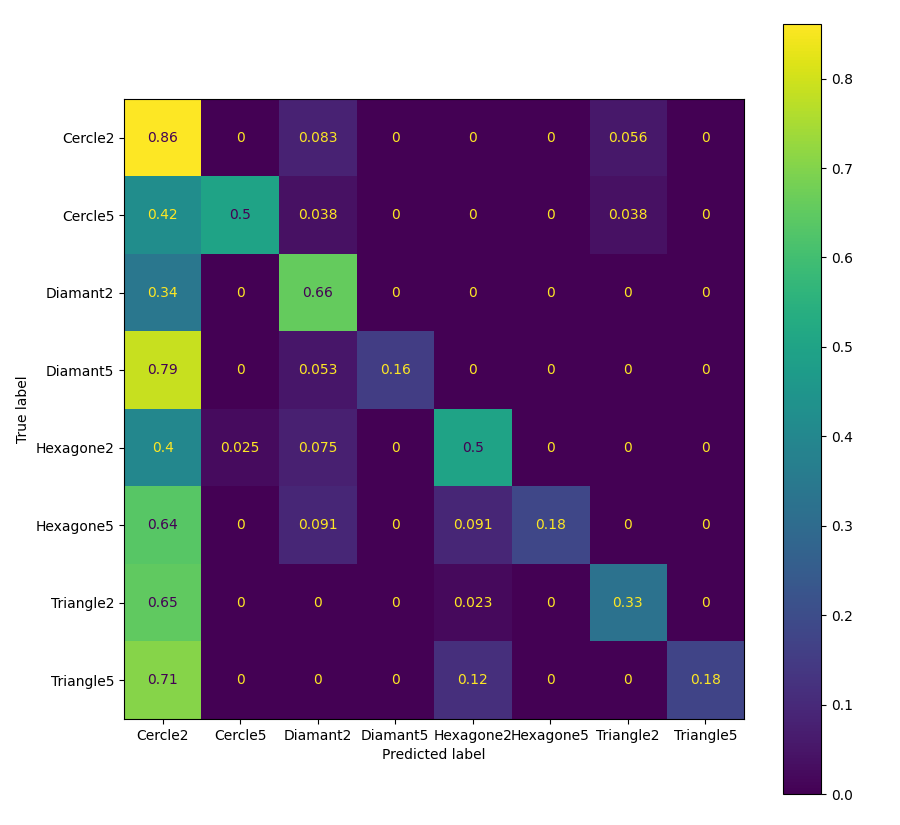

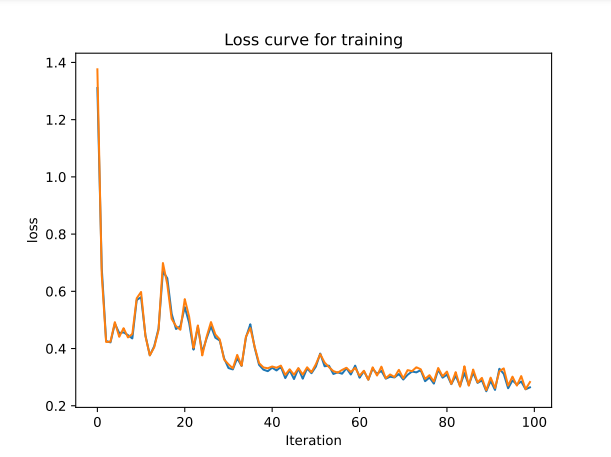

# Choix des hyperparamètres

Nous avons utilisé une simple boucle pour tester le modèle avec différents hyperparamètres et avons choisi ceux qui donnaient la meilleure précision sur l'ensemble de validation.

In [ ]:
for i in range(30, 9, -1):
  for j in [0.0008, 0.0009, 0.001, 0.0011, 0.0012]:

    nn = NeuralNetwork(
      nb_input_nodes=40*40,
      nb_hidden_nodes=i,
      nb_output_nodes=8,
      learning_rate=j,
      epochs=100
    )

    ...

***

# Comparaison des modèles

In [3]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
import numpy as np
import os
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, auc, \
    roc_curve, confusion_matrix, classification_report, accuracy_score, \
        cohen_kappa_score, roc_auc_score, roc_curve

### charger et visualiser les caractéristiques de notre jeu de données

Notre dataset est stocké au sein d'une classe :

In [5]:
class dataset():
    def __init__(self, root) :
        self.root = root
        self.data = np.array([], dtype=np.int32)
        self.target = np.array([], dtype=np.int32)
        self.target_names = np.array([], dtype=np.int32)
        self.feature_names = np.array([], dtype=np.int32)

        nb_class = 0
        nb_images = 0


        for i in os.listdir(self.root) :
            for j in os.listdir(self.root + str(i)) :
                self.target_names = np.append(self.target_names,j)
                nb_class += 1
                for k in os.listdir(self.root + str(i) + '/' + str(j)) :
                    if nb_images%1000 == 0 :
                        print('{} images importées'.format(nb_images))
                    self.target = np.append(self.target,nb_class)
                    nb_images += 1
                    img = Image.open(self.root + str(i) + '/' + str(j) + '/' + str(k)).convert('L')
                    self.data = np.append(self.data,np.asarray(img))
        self.data = np.reshape(self.data,(nb_images,1600))

        for i in range(40) :
            for j in range(40) :
                self.feature_names = np.append(self.feature_names,'pixels ' + str(i) + '_' + str(j))

On instancie un dataset avec nos images augmentées :

In [6]:
dataset = dataset('../output/augmented/')

dataset.data.shape

0 images importées
1000 images importées
2000 images importées
3000 images importées
4000 images importées
5000 images importées
6000 images importées
7000 images importées
8000 images importées
9000 images importées
10000 images importées
11000 images importées
12000 images importées
13000 images importées
14000 images importées
15000 images importées
16000 images importées
17000 images importées
18000 images importées
19000 images importées


(19512, 1600)

On affiche la corrélation entre quelques primitives :

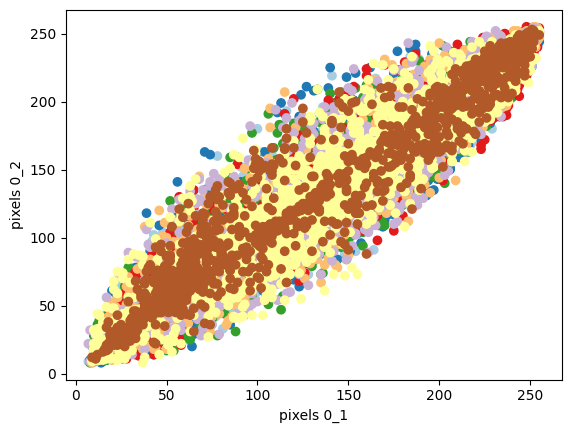

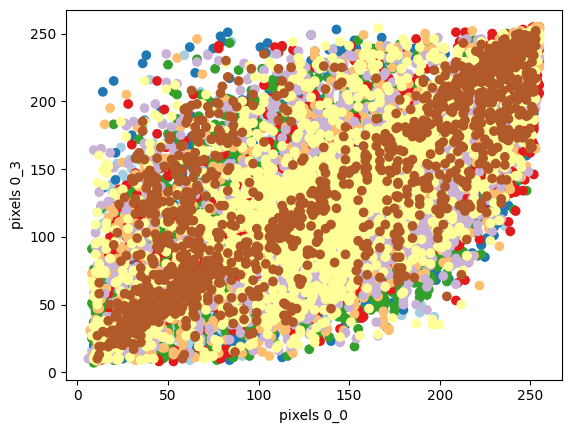

In [7]:
plt.scatter(dataset.data[:,1],dataset.data[:,2],c=dataset.target, cmap=plt.cm.Paired)
plt.xlabel(dataset.feature_names[1])
plt.ylabel(dataset.feature_names[2])
plt.show()

plt.scatter(dataset.data[:,0],dataset.data[:,3],c=dataset.target, cmap=plt.cm.Paired)
plt.xlabel(dataset.feature_names[0])
plt.ylabel(dataset.feature_names[3])
plt.show()

### Préparer le X_train, Y_train, X_test et Y_test

On divise le dataset en deux, les données et les résultats :

In [8]:
X = dataset.data 
Y = dataset.target

print(X.shape)
print(Y.shape)

(19512, 1600)
(19512,)


On modifie Y pour qu'il contienne en un vecteur tous les résultats :

In [9]:
from sklearn.preprocessing import label_binarize

# on modifie le nombre de classes en fonction du dataset directement
Y = label_binarize(Y, classes=range(len(dataset.target_names)))
print(Y.shape)


(19512, 8)


On divise le dataset en deux : celui de test et celui d'entrainement :

In [10]:
# test_size correspond à la proportion de test, ici 40%
# random_state sert à garder la même valeur d'aléatoire d'un appel de fonction à l'autre lorsqu'on mélange les données  
x_train_val,x_test,y_train_val,y_test = train_test_split(X, Y, test_size=0.2,random_state=4)

# on crée un troisième jeu de données, celui de validation
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val, test_size=0.25,random_state=2)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(11706, 1600) (11706, 8)
(3903, 1600) (3903, 8)
(3903, 1600) (3903, 8)


### Les modèles d'apprentissage : KNN, SVM, NN, CNN

#### 1- K-nearest neighbors algorithm (KNN)

Veuillez référer à ce lien afin de comprendre les parametres de cet algorithme  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

##### A- Phase d'apprentissage

In [11]:
# on teste différentes valeurs de k pour trouver le meilleur résultat
k_range = range(1,15)
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train,y_train) 
        y_pred=knn.predict(x_val) # on teste les hyper-paramètres avec l'ensemble de validation
        print('k = {}\t=>\tscore = {:2.3%}'.format(k,metrics.accuracy_score(y_val,y_pred)))

k = 1	=>	score = 91.468%
k = 2	=>	score = 85.037%
k = 3	=>	score = 88.778%
k = 4	=>	score = 83.423%
k = 5	=>	score = 85.780%
k = 6	=>	score = 82.168%
k = 7	=>	score = 83.756%
k = 8	=>	score = 80.297%
k = 9	=>	score = 81.553%
k = 10	=>	score = 78.632%
k = 11	=>	score = 79.785%
k = 12	=>	score = 76.736%
k = 13	=>	score = 77.556%
k = 14	=>	score = 74.994%


On choisit k=1, ce qui donne le meilleur résultat pour nos données.

In [12]:
import time

start = time.time()

knn = KNeighborsClassifier(n_neighbors=1)

# on entraine le modèle
knn.fit(x_train_val,y_train_val) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn))

temps d'apprentissage : 0.006 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [13]:
start = time.time()

y_pred_knn = knn.predict(x_test)

end = time.time()

testing_time_knn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn))
print(y_pred.shape, y_test.shape)

temps de test : 2.928 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

On affiche la matrice de confusion de la prédiction :

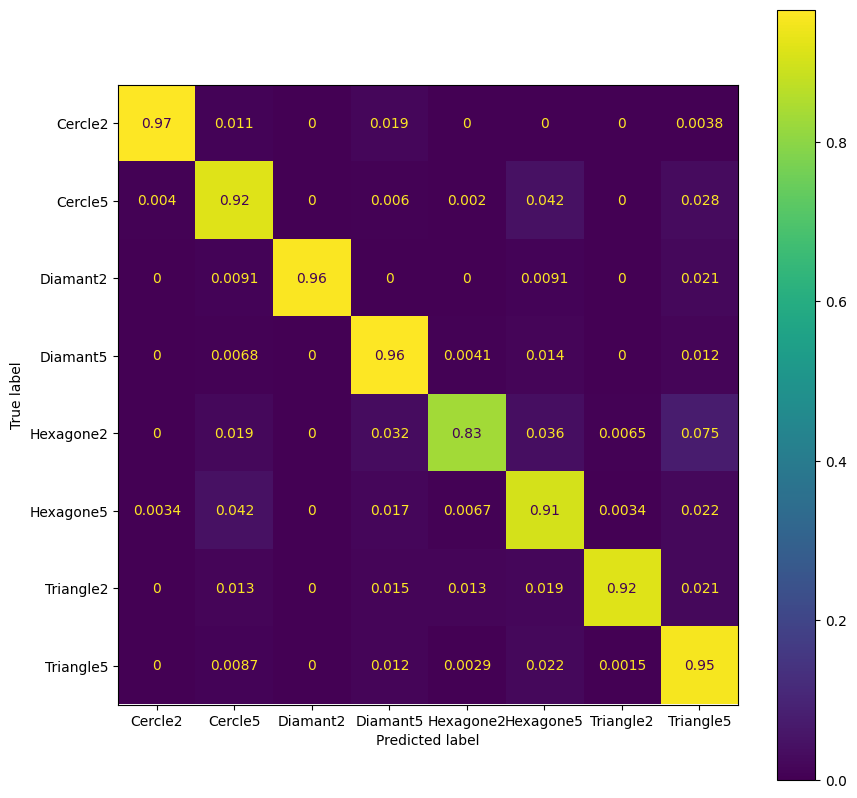

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = dataset.target_names.tolist()

# the confusion matrix is normalized over the true conditions (e.g. rows);
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_knn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

###### Accuracy, precision, recall, f1-score.

In [15]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print('Accuracy: %f' % accuracy_knn, '\n')
# precision tp / (tp + fp)
precision_knn = precision_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('Precision: %f' % precision_knn, '\n')
# recall: tp / (tp + fn)
recall_knn = recall_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('Recall: %f' % recall_knn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn = f1_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn, '\n')

Accuracy: 0.931335 

Precision: 0.818609 

Recall: 0.806652 

F1 score: 0.811841 



#### 2- Support vector machine (SVM) model

Veuillez référer à ce lien afin de comprendre les parametres de cet algorithme  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

##### A- Phase d'apprentissage

In [16]:
from sklearn.svm import SVC

start = time.time()

svm = SVC(kernel = 'linear', random_state = 0)

#Entrainer le modèle pour les données

svm.fit(x_train_val, y_train_val.argmax(axis=1))

end = time.time()

training_time_svc = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svc))

temps d'apprentissage : 119.115 secondes


##### B- Phase de prédiction ou de test

In [17]:
start = time.time()

y_pred_svm = svm.predict(x_test)

end = time.time()

testing_time_svc = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svc))

temps de test : 11.933 secondes


##### C- Évaluation

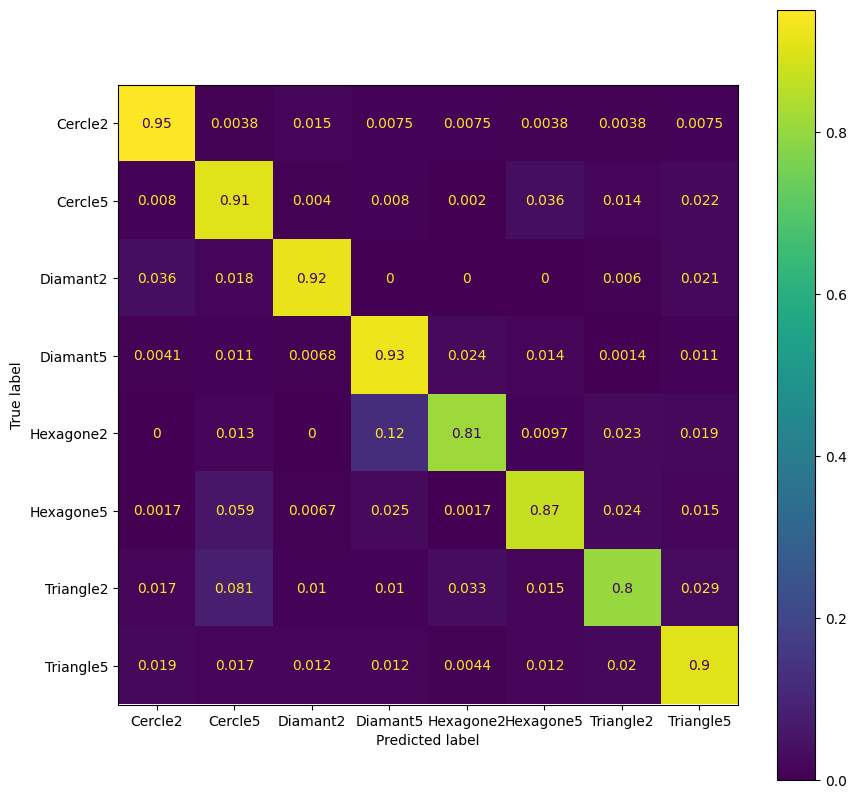

In [18]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_svm,
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

###### Accuracy, precision, recall, f1-score.

In [19]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm = accuracy_score(y_test.argmax(axis=1), y_pred_svm)
print('Accuracy: %f' % accuracy_svm, '\n')
# precision tp / (tp + fp)
precision_svm = precision_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('Precision: %f' % precision_svm, '\n')
# recall: tp / (tp + fn)
recall_svm = recall_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('Recall: %f' % recall_svm, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm = f1_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm, '\n')

Accuracy: 0.888035 

Precision: 0.884727 

Recall: 0.886271 

F1 score: 0.884406 



#### 3- Réseau de neurone (NN) model

Veuillez se référer à ce lien pour voir comment construire un réseau de neurones à Keras https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5

In [20]:
#conda install -c anaconda keras
#conda update -n base conda

In [21]:
%pip install tensorflow
%pip install keras

import keras
#import tensorflow as tf

#Neural network module
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.layers import BatchNormalization 
from keras.utils import np_utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


##### A-  Créer le modèle du réseau de neurone

In [41]:
NN=Sequential()
NN.add(Dense(1000,input_dim=len(dataset.feature_names),activation='relu'))
NN.add(Dense(500,activation='relu'))
NN.add(Dense(300,activation='relu'))
NN.add(Dropout(0.2))
NN.add(Dense(len(dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.000001)
NN.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [42]:
NN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1000)              1601000   
                                                                 
 dense_17 (Dense)            (None, 500)               500500    
                                                                 
 dense_18 (Dense)            (None, 300)               150300    
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_19 (Dense)            (None, 8)                 2408      
                                                                 
Total params: 2,254,208
Trainable params: 2,254,208
Non-trainable params: 0
_________________________________________________________________


##### B- Phase d'apprentissage

In [43]:
start = time.time()

history= NN.fit(x_train,y_train,validation_data=(x_val,y_val), validation_split= 0.2, batch_size=20,epochs=10,verbose=1)

end = time.time()

training_time_nn = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn))

Epoch 1/10
586/586 [==============================] - 7s 12ms/step - loss: 57.2128 - accuracy: 0.1638 - val_loss: 17.7059 - val_accuracy: 0.2808
Epoch 2/10
586/586 [==============================] - 7s 11ms/step - loss: 32.9216 - accuracy: 0.2283 - val_loss: 12.1331 - val_accuracy: 0.3864
Epoch 3/10
586/586 [==============================] - 7s 11ms/step - loss: 23.9554 - accuracy: 0.2743 - val_loss: 8.9525 - val_accuracy: 0.4548
Epoch 4/10
586/586 [==============================] - 6s 11ms/step - loss: 18.3705 - accuracy: 0.3246 - val_loss: 7.4252 - val_accuracy: 0.5129
Epoch 5/10
586/586 [==============================] - 7s 11ms/step - loss: 15.4409 - accuracy: 0.3661 - val_loss: 6.1561 - val_accuracy: 0.5591
Epoch 6/10
586/586 [==============================] - 7s 11ms/step - loss: 13.4697 - accuracy: 0.3904 - val_loss: 5.4656 - val_accuracy: 0.5783
Epoch 7/10
586/586 [==============================] - 7s 11ms/step - loss: 11.4490 - accuracy: 0.4288 - val_loss: 4.9494 - val_accurac

--------------------------------------------------------------------
Evaluate the trained CNN ...


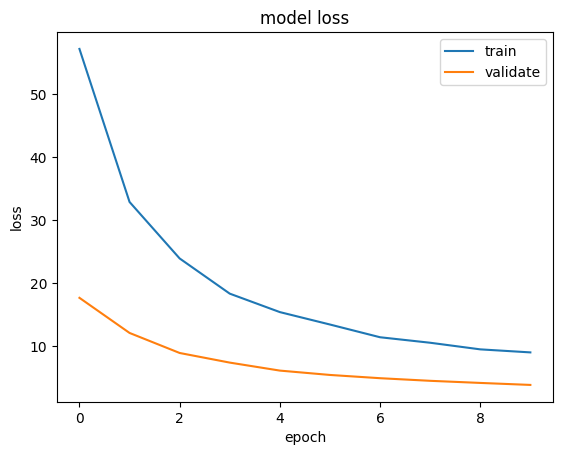

In [44]:
print('--------------------------------------------------------------------\n'
      'Evaluate the trained CNN ...')

# plotting the metrics

fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

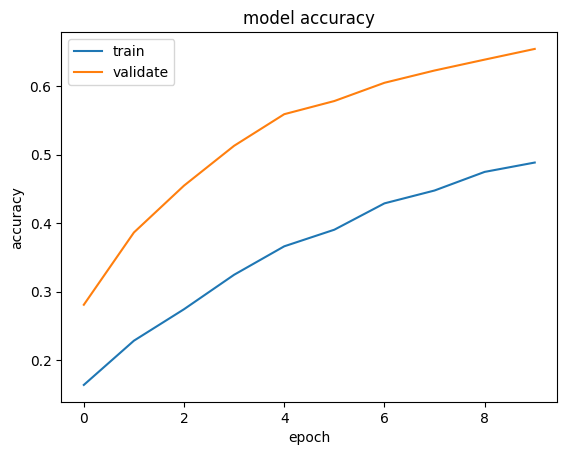

In [45]:
# plotting the metrics

fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

##### C- Phase de prédiction

In [46]:
start = time.time()

y_pred_nn=NN.predict(x_test)

end = time.time()

testing_time_nn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.698 secondes


##### D- Évaluation

In [47]:
acc_train = NN.evaluate(x_train, y_train)
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = NN.evaluate(x_test, y_test)
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

366/366 [==============================] - 2s 5ms/step - loss: 3.3796 - accuracy: 0.6744
Loss_train: 3.3796303272247314  Accuracy_train: 0.6744404435157776
122/122 [==============================] - 1s 5ms/step - loss: 3.8563 - accuracy: 0.6544
Loss_test: 3.8563425540924072  Accuracy_test: 0.6543684601783752


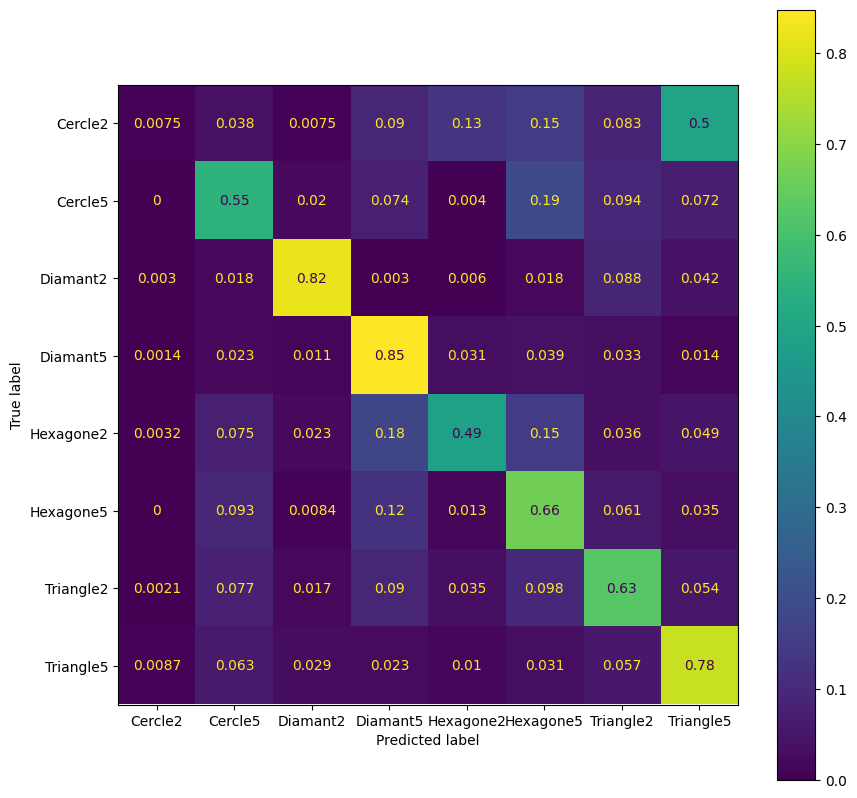

In [48]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_nn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

In [49]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn = accuracy_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn, '\n')
# precision tp / (tp + fp)
precision_nn = precision_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn, '\n')
# recall: tp / (tp + fn)
recall_nn = recall_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn = f1_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn, '\n')

Accuracy: 0.654368 

Precision: 0.818609 

Recall: 0.597892 

F1 score: 0.584672 



#### 3- Réseau de neurone à convolution (CNN) model



In [50]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [51]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(x_train.shape, x_test.shape)

(11706, 1600, 1) (3903, 1600, 1)


##### A-  Créer le modèle du CNN

In [73]:
cnn = Sequential()
cnn.add(Conv1D(64, 2, activation="relu", input_shape=(x_train.shape[1],1)))
cnn.add(Dense(16, activation="relu"))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(len(dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=0.000000001)
cnn.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])
cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 1599, 64)          192       
                                                                 
 dense_34 (Dense)            (None, 1599, 16)          1040      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 799, 16)          0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 12784)             0         
                                                                 
 dense_35 (Dense)            (None, 8)                 102280    
                                                                 
Total params: 103,512
Trainable params: 103,512
Non-trainable params: 0
_______________________________________________

##### B- Phase d'apprentissage

In [74]:
start = time.time()

history=cnn.fit(x_train, y_train.argmax(axis=1),
                    validation_split= 0.2, batch_size=16,epochs=10, verbose=1)

end = time.time()

training_time_cnn = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn))

Epoch 1/10
586/586 [==============================] - 9s 14ms/step - loss: 19.5431 - accuracy: 0.1939 - val_loss: 2.0330 - val_accuracy: 0.2011
Epoch 2/10
586/586 [==============================] - 9s 15ms/step - loss: 2.0271 - accuracy: 0.1951 - val_loss: 2.0222 - val_accuracy: 0.2011
Epoch 3/10
586/586 [==============================] - 8s 14ms/step - loss: 2.0215 - accuracy: 0.1951 - val_loss: 2.0193 - val_accuracy: 0.2011
Epoch 4/10
586/586 [==============================] - 8s 14ms/step - loss: 2.0200 - accuracy: 0.1951 - val_loss: 2.0182 - val_accuracy: 0.2011
Epoch 5/10
586/586 [==============================] - 8s 14ms/step - loss: 2.0195 - accuracy: 0.1951 - val_loss: 2.0176 - val_accuracy: 0.2011
Epoch 6/10
586/586 [==============================] - 8s 14ms/step - loss: 2.0194 - accuracy: 0.1951 - val_loss: 2.0173 - val_accuracy: 0.2011
Epoch 7/10
586/586 [==============================] - 8s 13ms/step - loss: 2.0193 - accuracy: 0.1951 - val_loss: 2.0172 - val_accuracy: 0.201

--------------------------------------------------------------------
Evaluate the trained CNN ...


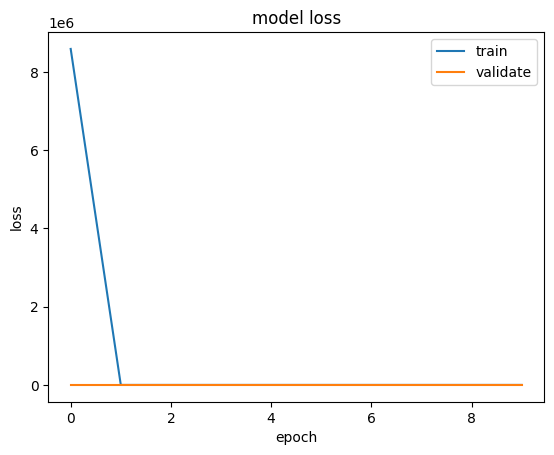

In [65]:
print('--------------------------------------------------------------------\n'
      'Evaluate the trained CNN ...')

# plotting the metrics

fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()


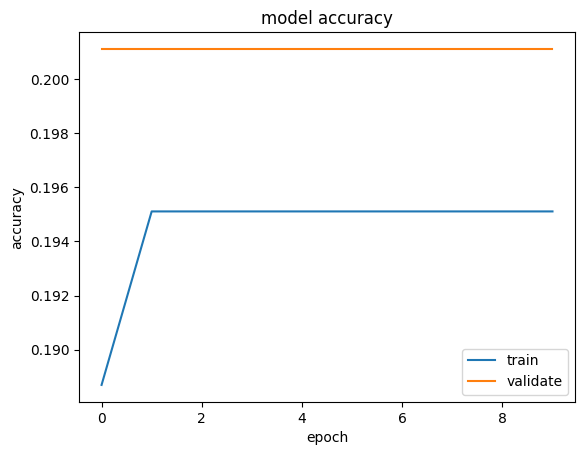

In [66]:
# plotting the metrics

fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

##### C- Phase de prédiction

In [67]:
start = time.time()

y_pred_cnn = cnn.predict(x_test)

end = time.time()

testing_time_cnn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn))

122/122 [==============================] - 1s 10ms/step
temps de test : 1.470 secondes


##### D- Évaluation

In [57]:
acc_train = cnn.evaluate(x_train, y_train.argmax(axis=1))
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = cnn.evaluate(x_test, y_test.argmax(axis=1))
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

366/366 [==============================] - 4s 11ms/step - loss: 2.0187 - accuracy: 0.1963
Loss_train: 2.018681764602661  Accuracy_train: 0.19630958139896393
122/122 [==============================] - 1s 10ms/step - loss: 2.0229 - accuracy: 0.1758
Loss_test: 2.0228724479675293  Accuracy_test: 0.17576223611831665


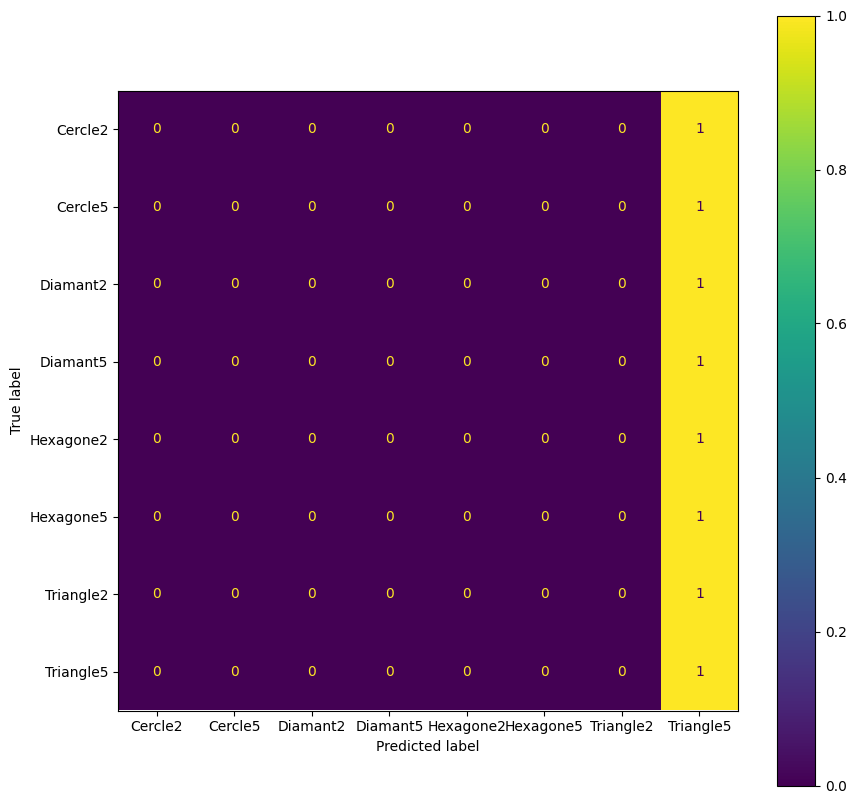

In [58]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_cnn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

In [ ]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn = accuracy_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn, '\n')
# precision tp / (tp + fp)
precision_cnn = precision_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn, '\n')
# recall: tp / (tp + fn)
recall_cnn = recall_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn = f1_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn, '\n')

### Comparaison